We will work with a star catalogue of 240 stars described by the following information:

- Temperature (in Kelvin)
- Luminosity (L/Lo)
- Radius (R/Ro)
- Absolute magnitude (Mv)

We also have the following data for each star:

- Color (Red/Orange/Yellow/White/Blue)
- Spectral class ('A', 'B', 'F', 'G', 'K', 'M', 'O')
- Star type (Brown dwarf/Red dwarf/White dwarf/Main sequence/Supergiant/Hypergiant)

This dataset has been collected by [Deepraj Baidya](https://github.com/deepraj1729) and was originally published on [Kaggle](https://www.kaggle.com/deepu1109/star-dataset). 

In [149]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import random
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc


plt.rc('text', usetex=True)
plt.rc('font', family='serif')

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [150]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/nshaud/ml_for_astro/main/stars.csv", "stars.csv")

('stars.csv', <http.client.HTTPMessage at 0x7f40a99a4190>)

In [151]:
df_stars = pd.read_csv("stars.csv")

In [152]:
df_stars

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,Brown Dwarf,Red,M
1,3042,0.000500,0.1542,16.60,Brown Dwarf,Red,M
2,2600,0.000300,0.1020,18.70,Brown Dwarf,Red,M
3,2800,0.000200,0.1600,16.65,Brown Dwarf,Red,M
4,1939,0.000138,0.1030,20.06,Brown Dwarf,Red,M
...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,Hypergiant,Blue,O
236,30839,834042.000000,1194.0000,-10.63,Hypergiant,Blue,O
237,8829,537493.000000,1423.0000,-10.73,Hypergiant,White,A
238,9235,404940.000000,1112.0000,-11.23,Hypergiant,White,A


In [153]:
le = LabelEncoder() #it assign a unique int to every class

df_stars['Star type'] = le.fit_transform(df_stars['Star type']) #create the numbers
labels = le.inverse_transform(df_stars['Star type']) #go back to the previous labels
class_names = le.classes_ #classes_ attribute contains the list of unique star types in original, sorted in ascending order
print(class_names)

['Brown Dwarf' 'Hypergiant' 'Main Sequence' 'Red Dwarf' 'Supergiant'
 'White Dwarf']


We've seen this already last time. It is often grood practice to start with a statistical analysis of the dataset to answer the following questions:
* are there any missing values?
* are there NaNs in the data?

In [154]:
#Check and in case remove NaN values
T_dirty = df_stars['Temperature (K)']
L_dirty = df_stars['Luminosity(L/Lo)']
R_dirty = df_stars['Radius(R/Ro)']
AM_dirty = df_stars['Absolute magnitude(Mv)']

T = T_dirty[~np.isnan(T_dirty)]
R = R_dirty[~np.isnan(R_dirty)]
L = L_dirty[~np.isnan(L_dirty)]
AM = AM_dirty[~np.isnan(AM_dirty)]


In [155]:
print(len(T_dirty), len(T))
print(len(R_dirty), len(R))
print(len(L_dirty), len(L))
print(len(AM_dirty), len(AM))

240 240
240 240
240 240
240 240


In [156]:
#see if there are missing values per column
missing_per_column = df_stars.isnull().sum()
print(missing_per_column)

Temperature (K)           0
Luminosity(L/Lo)          0
Radius(R/Ro)              0
Absolute magnitude(Mv)    0
Star type                 0
Star color                0
Spectral Class            0
dtype: int64


No missing or NaN values in the data

### HR diagram

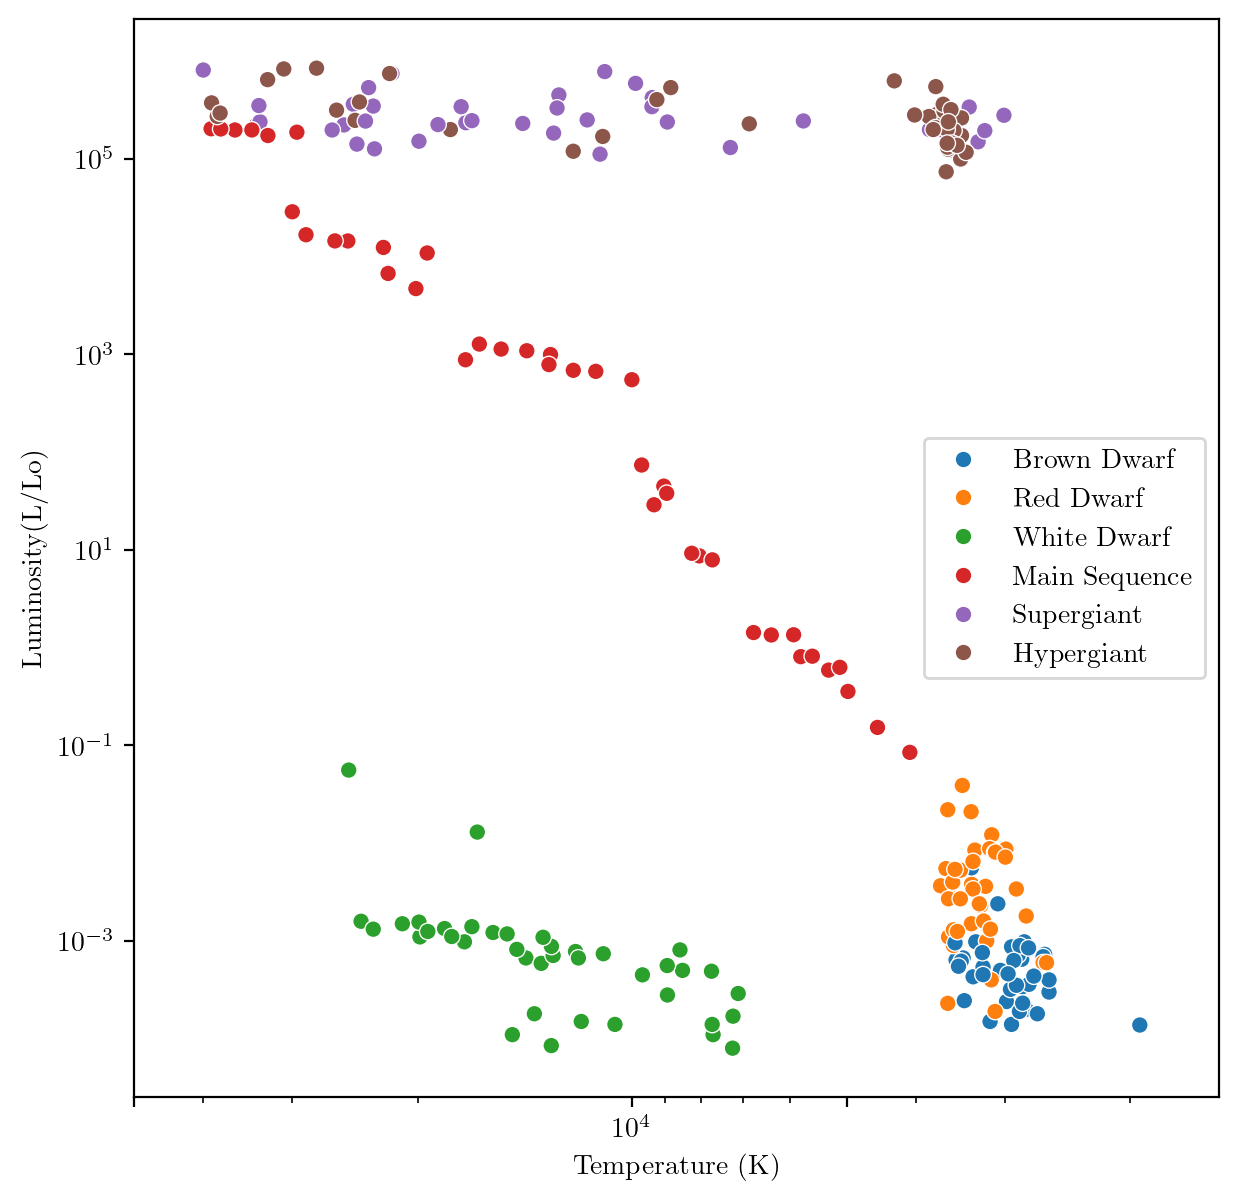

In [157]:
fig = plt.figure(figsize=(7, 7))
sns.scatterplot(data=df_stars, x='Temperature (K)', y='Luminosity(L/Lo)', hue=labels)

plt.xscale('log')
plt.yscale('log')
plt.xticks([5000, 10000, 50000])
plt.xlim(5e4, 1.5e3)
plt.show()

- Apply PCA to the dataset at your disposal (hint: don't use columns with labels, only those with real numbers).
- Project the dataset into the principal components, and do a scatter plot of the first two. 
- This will look terrible. Think about the units!
- Explore what happens if you rescale the data first.

In [158]:
np.random.seed(8)
nrows = len(df_stars['Temperature (K)'])
n_components = 4 

pca = PCA(n_components=n_components)
pca.fit(df_stars.iloc[:, :4]) #take only the first 5 col to avoid strings
stars_transformed = pca.transform(df_stars.iloc[:, :4])  

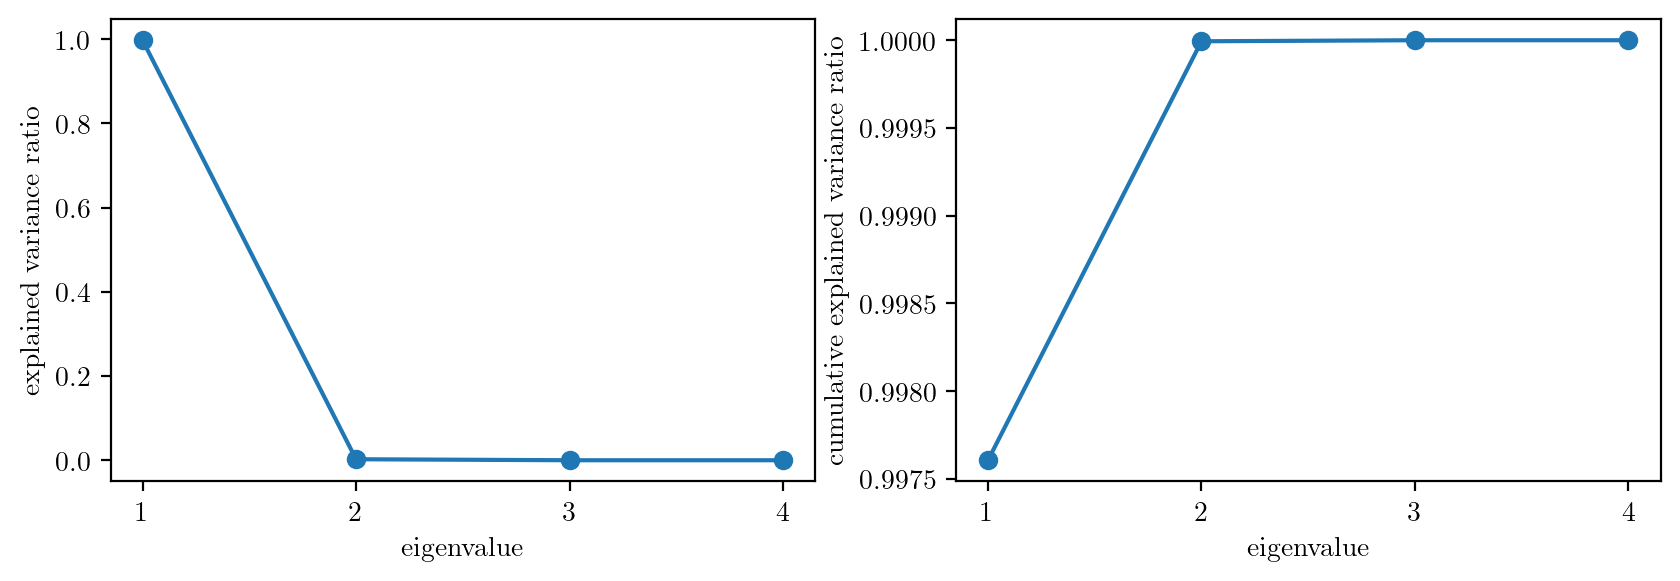

In [159]:
evals = pca.explained_variance_ratio_
# Plot the results
fig = plt.figure(figsize=(10, 3))

ax = fig.add_subplot(121)

ax.plot(range(1, n_components+1), evals)
ax.scatter(range(1, n_components+1), evals)

ax.set_xlabel("eigenvalue")
ax.set_ylabel("explained variance ratio")
ax.set_xticks(range(1, n_components+1))

ax = fig.add_subplot(122)

ax.plot(range(1, n_components+1), evals.cumsum())
ax.scatter(range(1, n_components+1), evals.cumsum())

ax.set_xlabel("eigenvalue")
ax.set_ylabel("cumulative explained variance ratio")
ax.set_xticks(range(1, n_components+1))

plt.show()

So with the first two components I can explain 100% of the variance

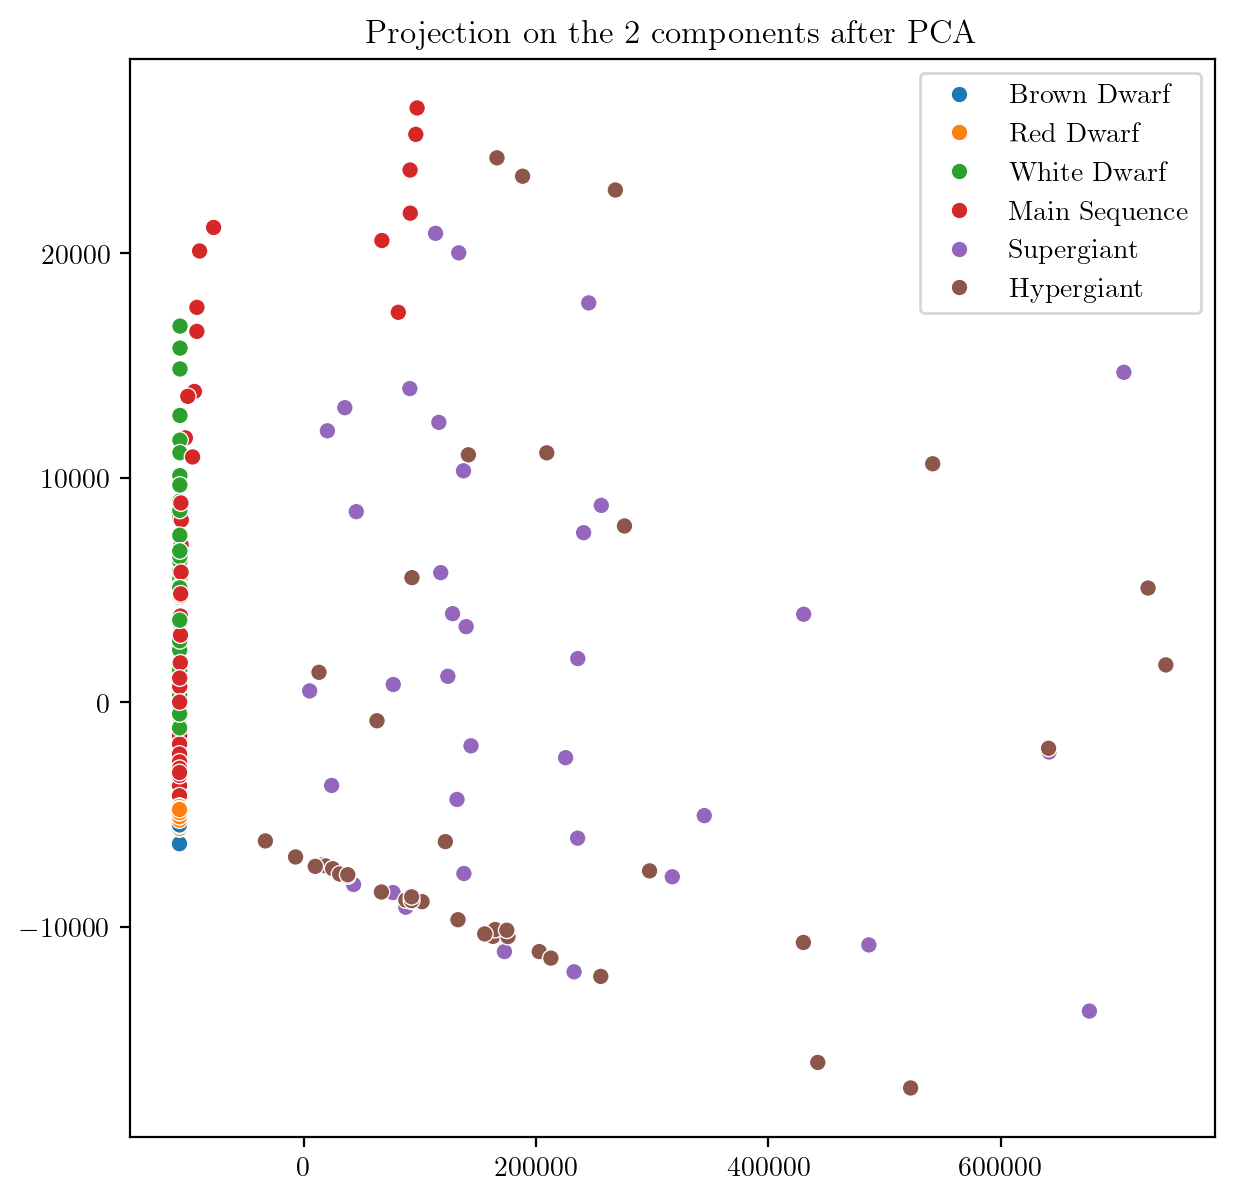

In [160]:
fig = plt.figure(figsize=(7, 7))
sns.scatterplot(x=stars_transformed[:,0], y=stars_transformed[:,1], hue=labels)
plt.title('Projection on the 2 components after PCA')
plt.show()

- You can try an linear, affine transformation such that each dimension goes between -1 and 1.
- Or (which is [the usual machine-learning approach](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)) standardize your data such that each dimension has mean=0 and variance=1. 
- Redo your PCA. Should be much much better.
- How much variance is explained by those two components?


### Manual rescaling between -1 and 1 :
$$ x' = 2 \cdot \frac{x-min(data)}{max(data)-min(data)} -1$$

In [161]:
def rescaling(x, data):
    return 2*((x-min(data))/(max(data)-min(data)))-1

In [162]:
my_stars_scaled = pd.DataFrame({
    col: [rescaling(value, df_stars[col]) for value in df_stars[col]] 
    for col in df_stars.columns[:4]
})

In [163]:
my_stars_scaled

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv)
0,-0.940674,-1.000000,-0.999834,0.753596
1,-0.942040,-1.000000,-0.999850,0.783615
2,-0.965266,-1.000000,-0.999904,0.914947
3,-0.954757,-1.000000,-0.999844,0.786742
4,-1.000000,-1.000000,-0.999903,1.000000
...,...,...,...,...
235,0.944300,-0.117445,0.391837,-0.875547
236,0.518615,0.963792,0.225555,-0.919325
237,-0.637950,0.265553,0.460608,-0.925578
238,-0.616615,-0.046549,0.141387,-0.956848


In [164]:
pca_my = PCA(n_components=n_components)
pca_my.fit(my_stars_scaled)
my_stars_sc_transformed = pca_my.transform(my_stars_scaled)  

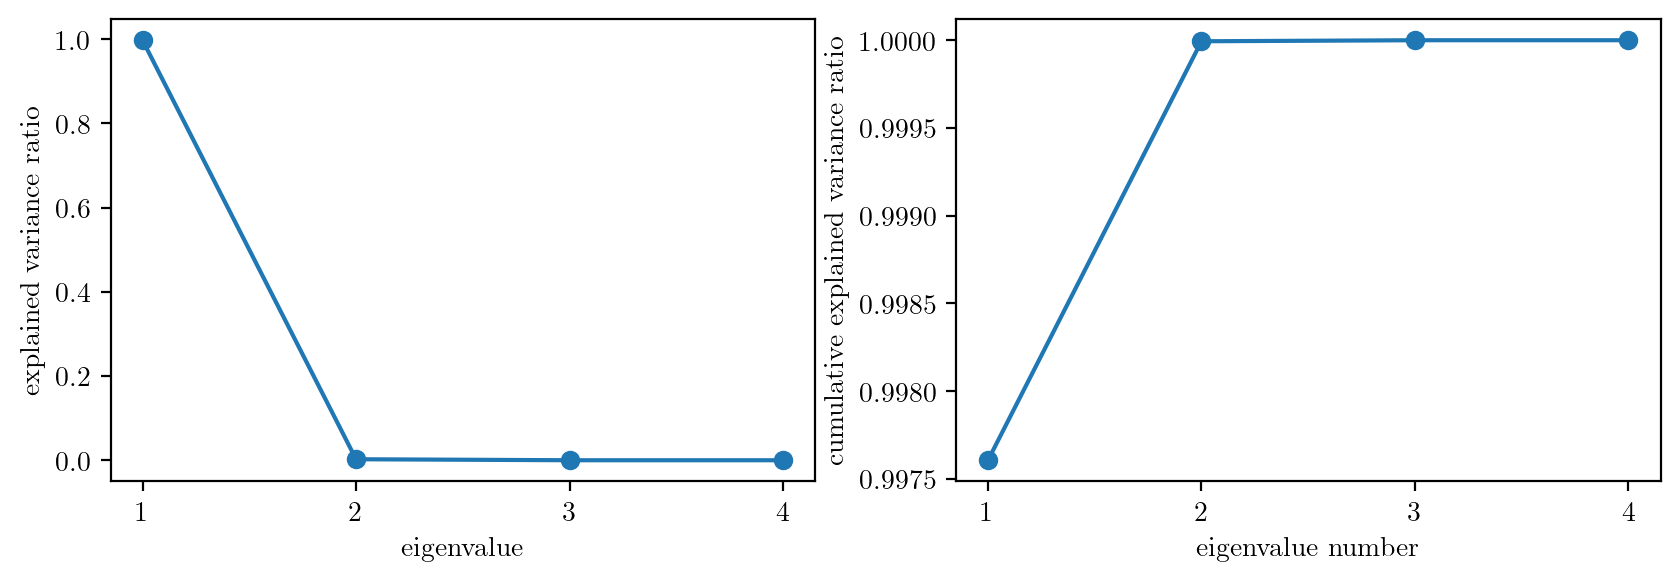

In [165]:
evals_my = pca.explained_variance_ratio_
# Plot the results
fig = plt.figure(figsize=(10, 3))

ax = fig.add_subplot(121)

ax.plot(range(1, n_components+1), evals_my)
ax.scatter(range(1, n_components+1), evals_my)

ax.set_xlabel("eigenvalue")
ax.set_ylabel("explained variance ratio")
ax.set_xticks(range(1, n_components+1))

ax = fig.add_subplot(122)

ax.plot(range(1, n_components+1), evals_my.cumsum())
ax.scatter(range(1, n_components+1), evals_my.cumsum())
ax.set_xticks(range(1, n_components+1))

ax.set_xlabel("eigenvalue number")
ax.set_ylabel("cumulative explained variance ratio")

plt.show()

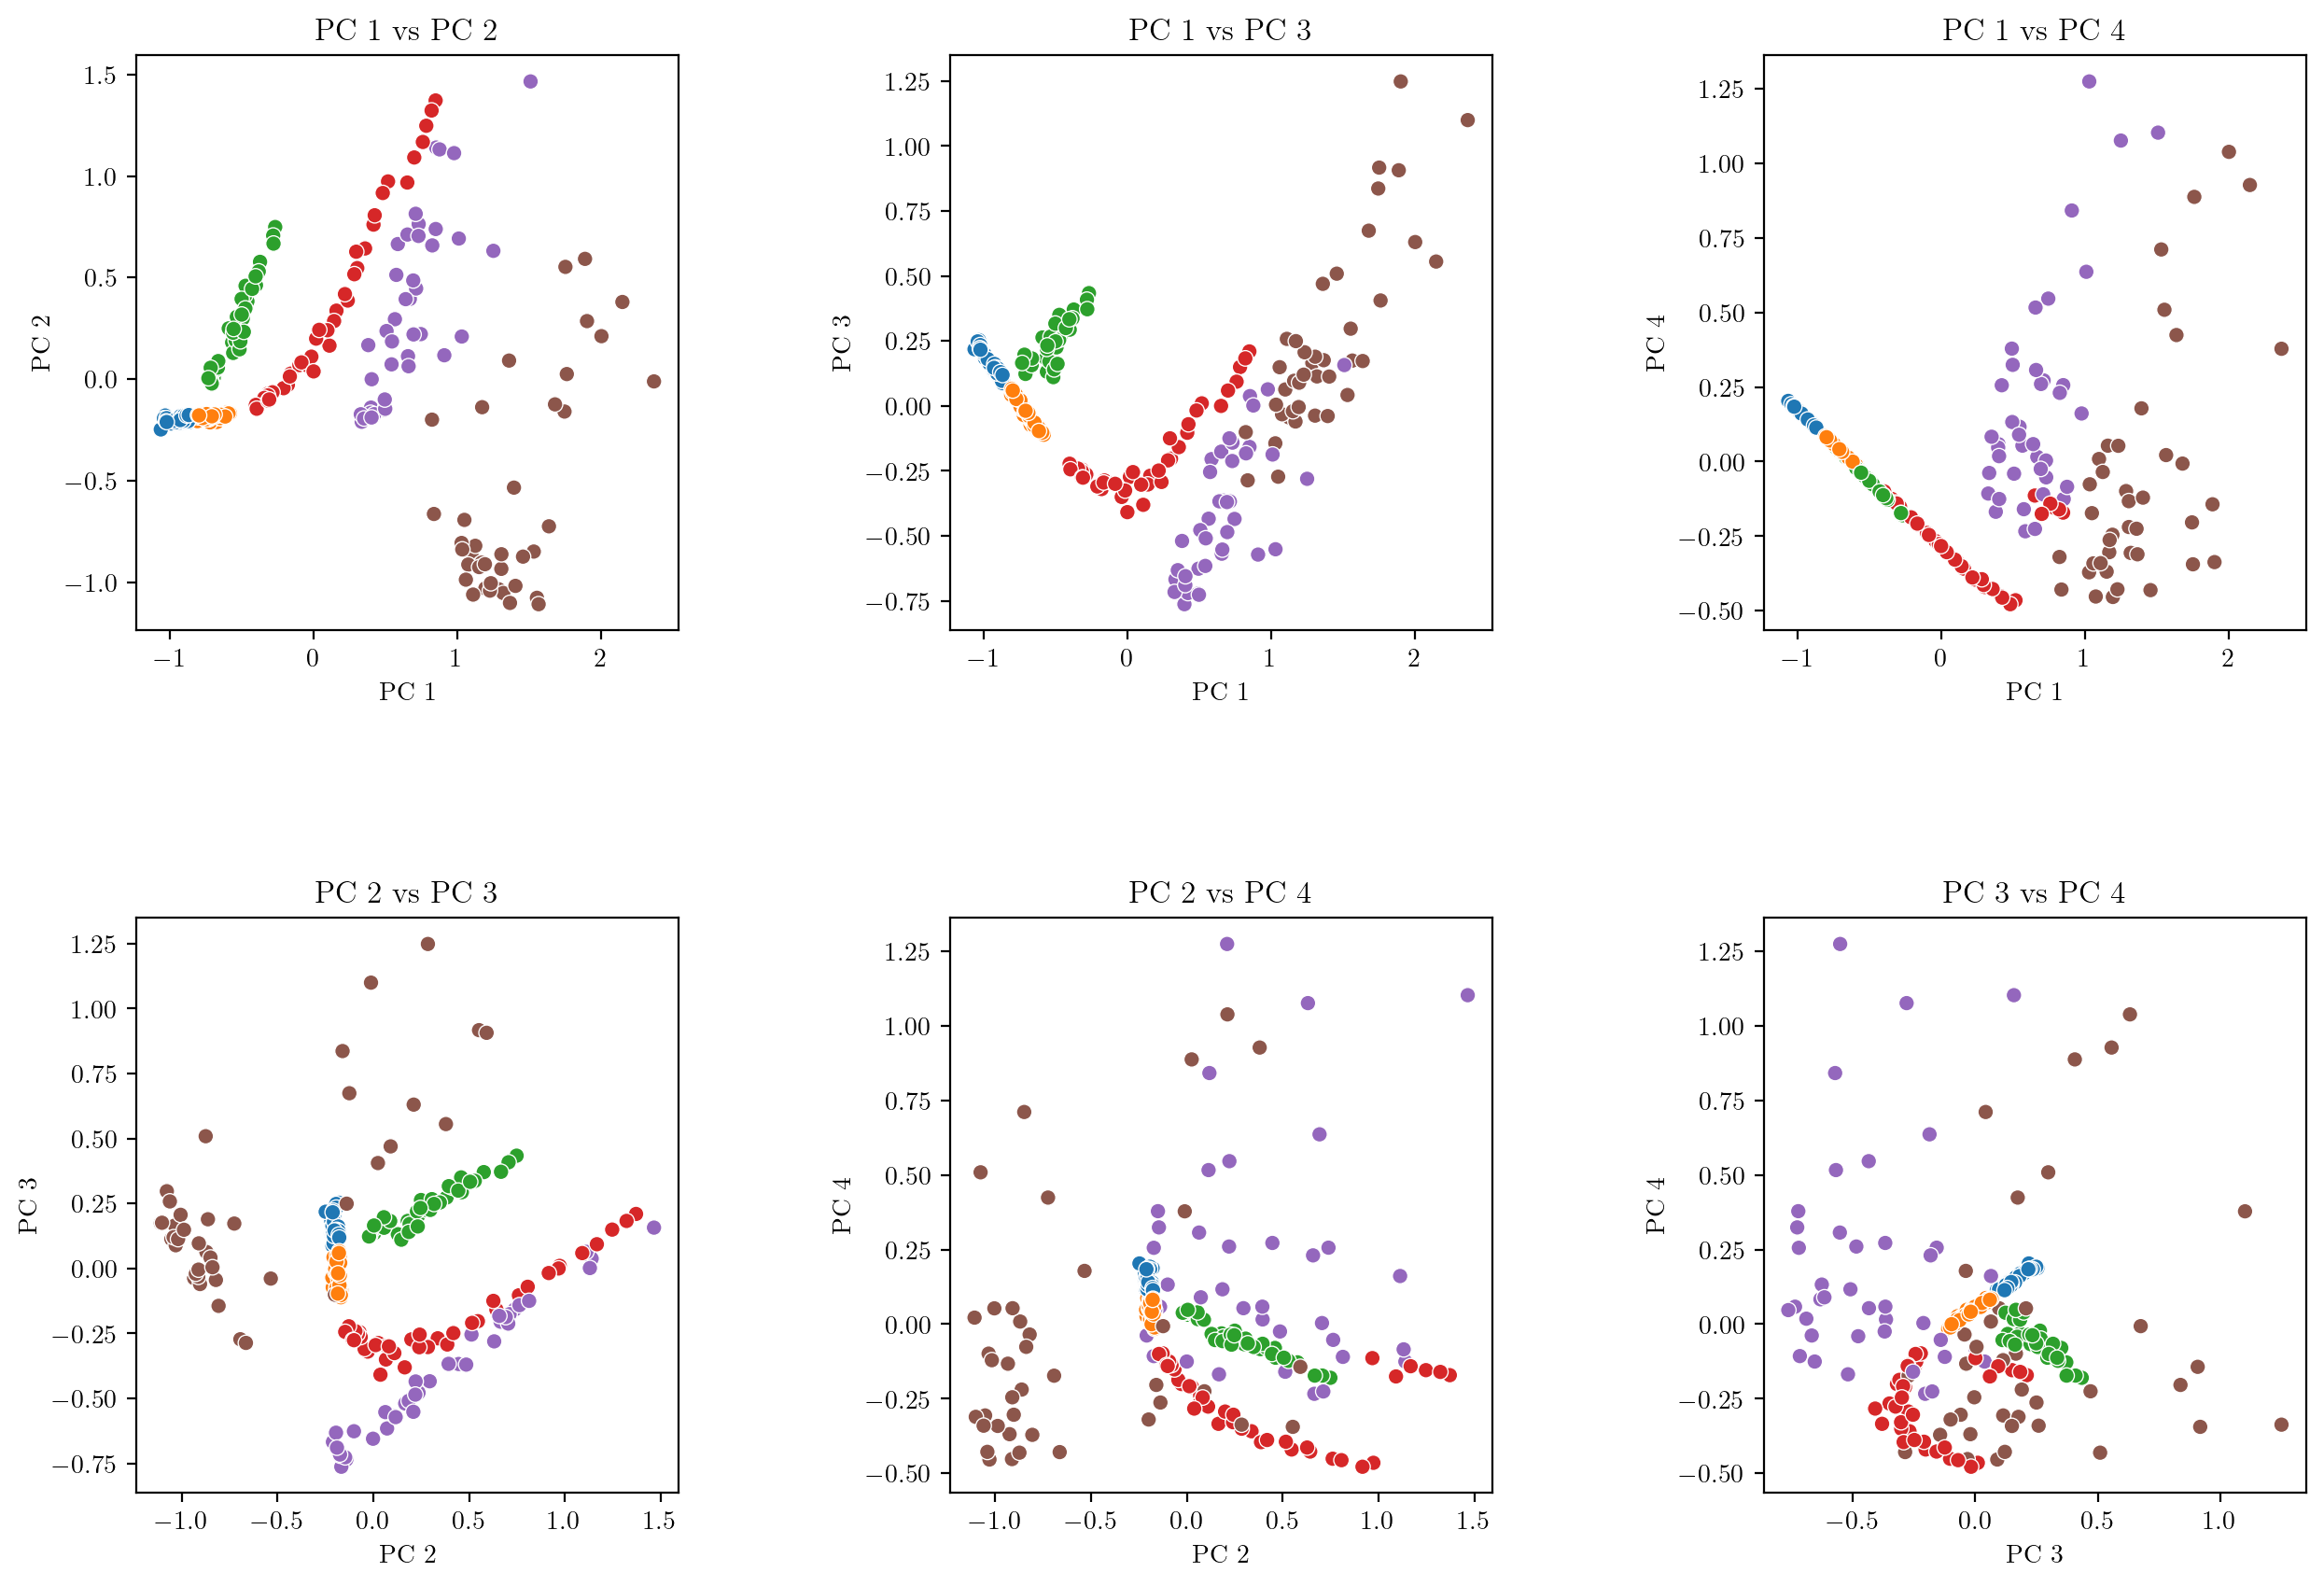

In [166]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
plt.subplots_adjust(hspace=0.5, wspace=0.5)

sns.scatterplot(x=my_stars_sc_transformed[:, 0], y=my_stars_sc_transformed[:, 1], hue=labels, ax=axs[0, 0], legend=False)
axs[0, 0].set_title('PC 1 vs PC 2')
axs[0, 0].set_xlabel('PC 1')
axs[0, 0].set_ylabel('PC 2')

sns.scatterplot(x=my_stars_sc_transformed[:, 0], y=my_stars_sc_transformed[:, 2], hue=labels, ax=axs[0, 1], legend=False)
axs[0, 1].set_title('PC 1 vs PC 3')
axs[0, 1].set_xlabel('PC 1')
axs[0, 1].set_ylabel('PC 3')

sns.scatterplot(x=my_stars_sc_transformed[:, 0], y=my_stars_sc_transformed[:, 3], hue=labels, ax=axs[0, 2], legend=False)
axs[0, 2].set_title('PC 1 vs PC 4')
axs[0, 2].set_xlabel('PC 1')
axs[0, 2].set_ylabel('PC 4')

sns.scatterplot(x=my_stars_sc_transformed[:, 1], y=my_stars_sc_transformed[:, 2], hue=labels, ax=axs[1, 0], legend=False)
axs[1, 0].set_title('PC 2 vs PC 3')
axs[1, 0].set_xlabel('PC 2')
axs[1, 0].set_ylabel('PC 3')

sns.scatterplot(x=my_stars_sc_transformed[:, 1], y=my_stars_sc_transformed[:, 3], hue=labels, ax=axs[1, 1], legend=False)
axs[1, 1].set_title('PC 2 vs PC 4')
axs[1, 1].set_xlabel('PC 2')
axs[1, 1].set_ylabel('PC 4')

sns.scatterplot(x=my_stars_sc_transformed[:, 2], y=my_stars_sc_transformed[:, 3], hue=labels, ax=axs[1, 2], legend=False)
axs[1, 2].set_title('PC 3 vs PC 4')
axs[1, 2].set_xlabel('PC 3')
axs[1, 2].set_ylabel('PC 4')

plt.show()


In [167]:
for idx, r in enumerate(evals):
    print(f'Comp {idx+1} - variance explained : {100*r:.2f} - cumulative : {evals.cumsum()[idx]*100}')

Comp 1 - variance explained : 99.76 - cumulative : 99.76063126866043
Comp 2 - variance explained : 0.24 - cumulative : 99.99942118846565
Comp 3 - variance explained : 0.00 - cumulative : 99.99999986572581
Comp 4 - variance explained : 0.00 - cumulative : 100.0


### Standard scaler

In [168]:
scaler = StandardScaler()
stars_scaled = scaler.fit_transform(df_stars.iloc[:, :4])

pca = PCA(n_components=n_components)
pca.fit(stars_scaled) 
stars_sc_transformed = pca.transform(stars_scaled)  

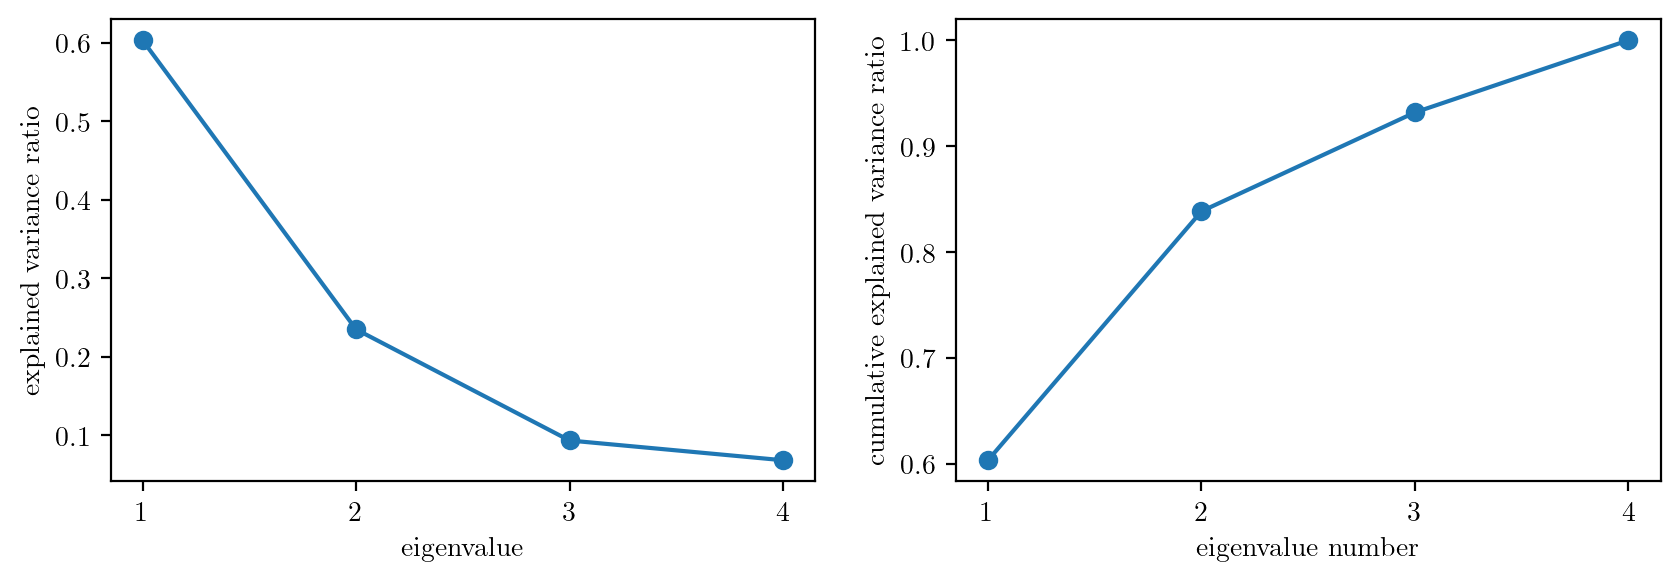

In [169]:
evals = pca.explained_variance_ratio_
# Plot the results
fig = plt.figure(figsize=(10, 3))

ax = fig.add_subplot(121)

ax.plot(range(1, n_components+1), evals)
ax.scatter(range(1, n_components+1), evals)

ax.set_xlabel("eigenvalue")
ax.set_ylabel("explained variance ratio")
ax.set_xticks(range(1, n_components+1))

ax = fig.add_subplot(122)

ax.plot(range(1, n_components+1), evals.cumsum())
ax.scatter(range(1, n_components+1), evals.cumsum())
ax.set_xticks(range(1, n_components+1))

ax.set_xlabel("eigenvalue number")
ax.set_ylabel("cumulative explained variance ratio")

plt.show()

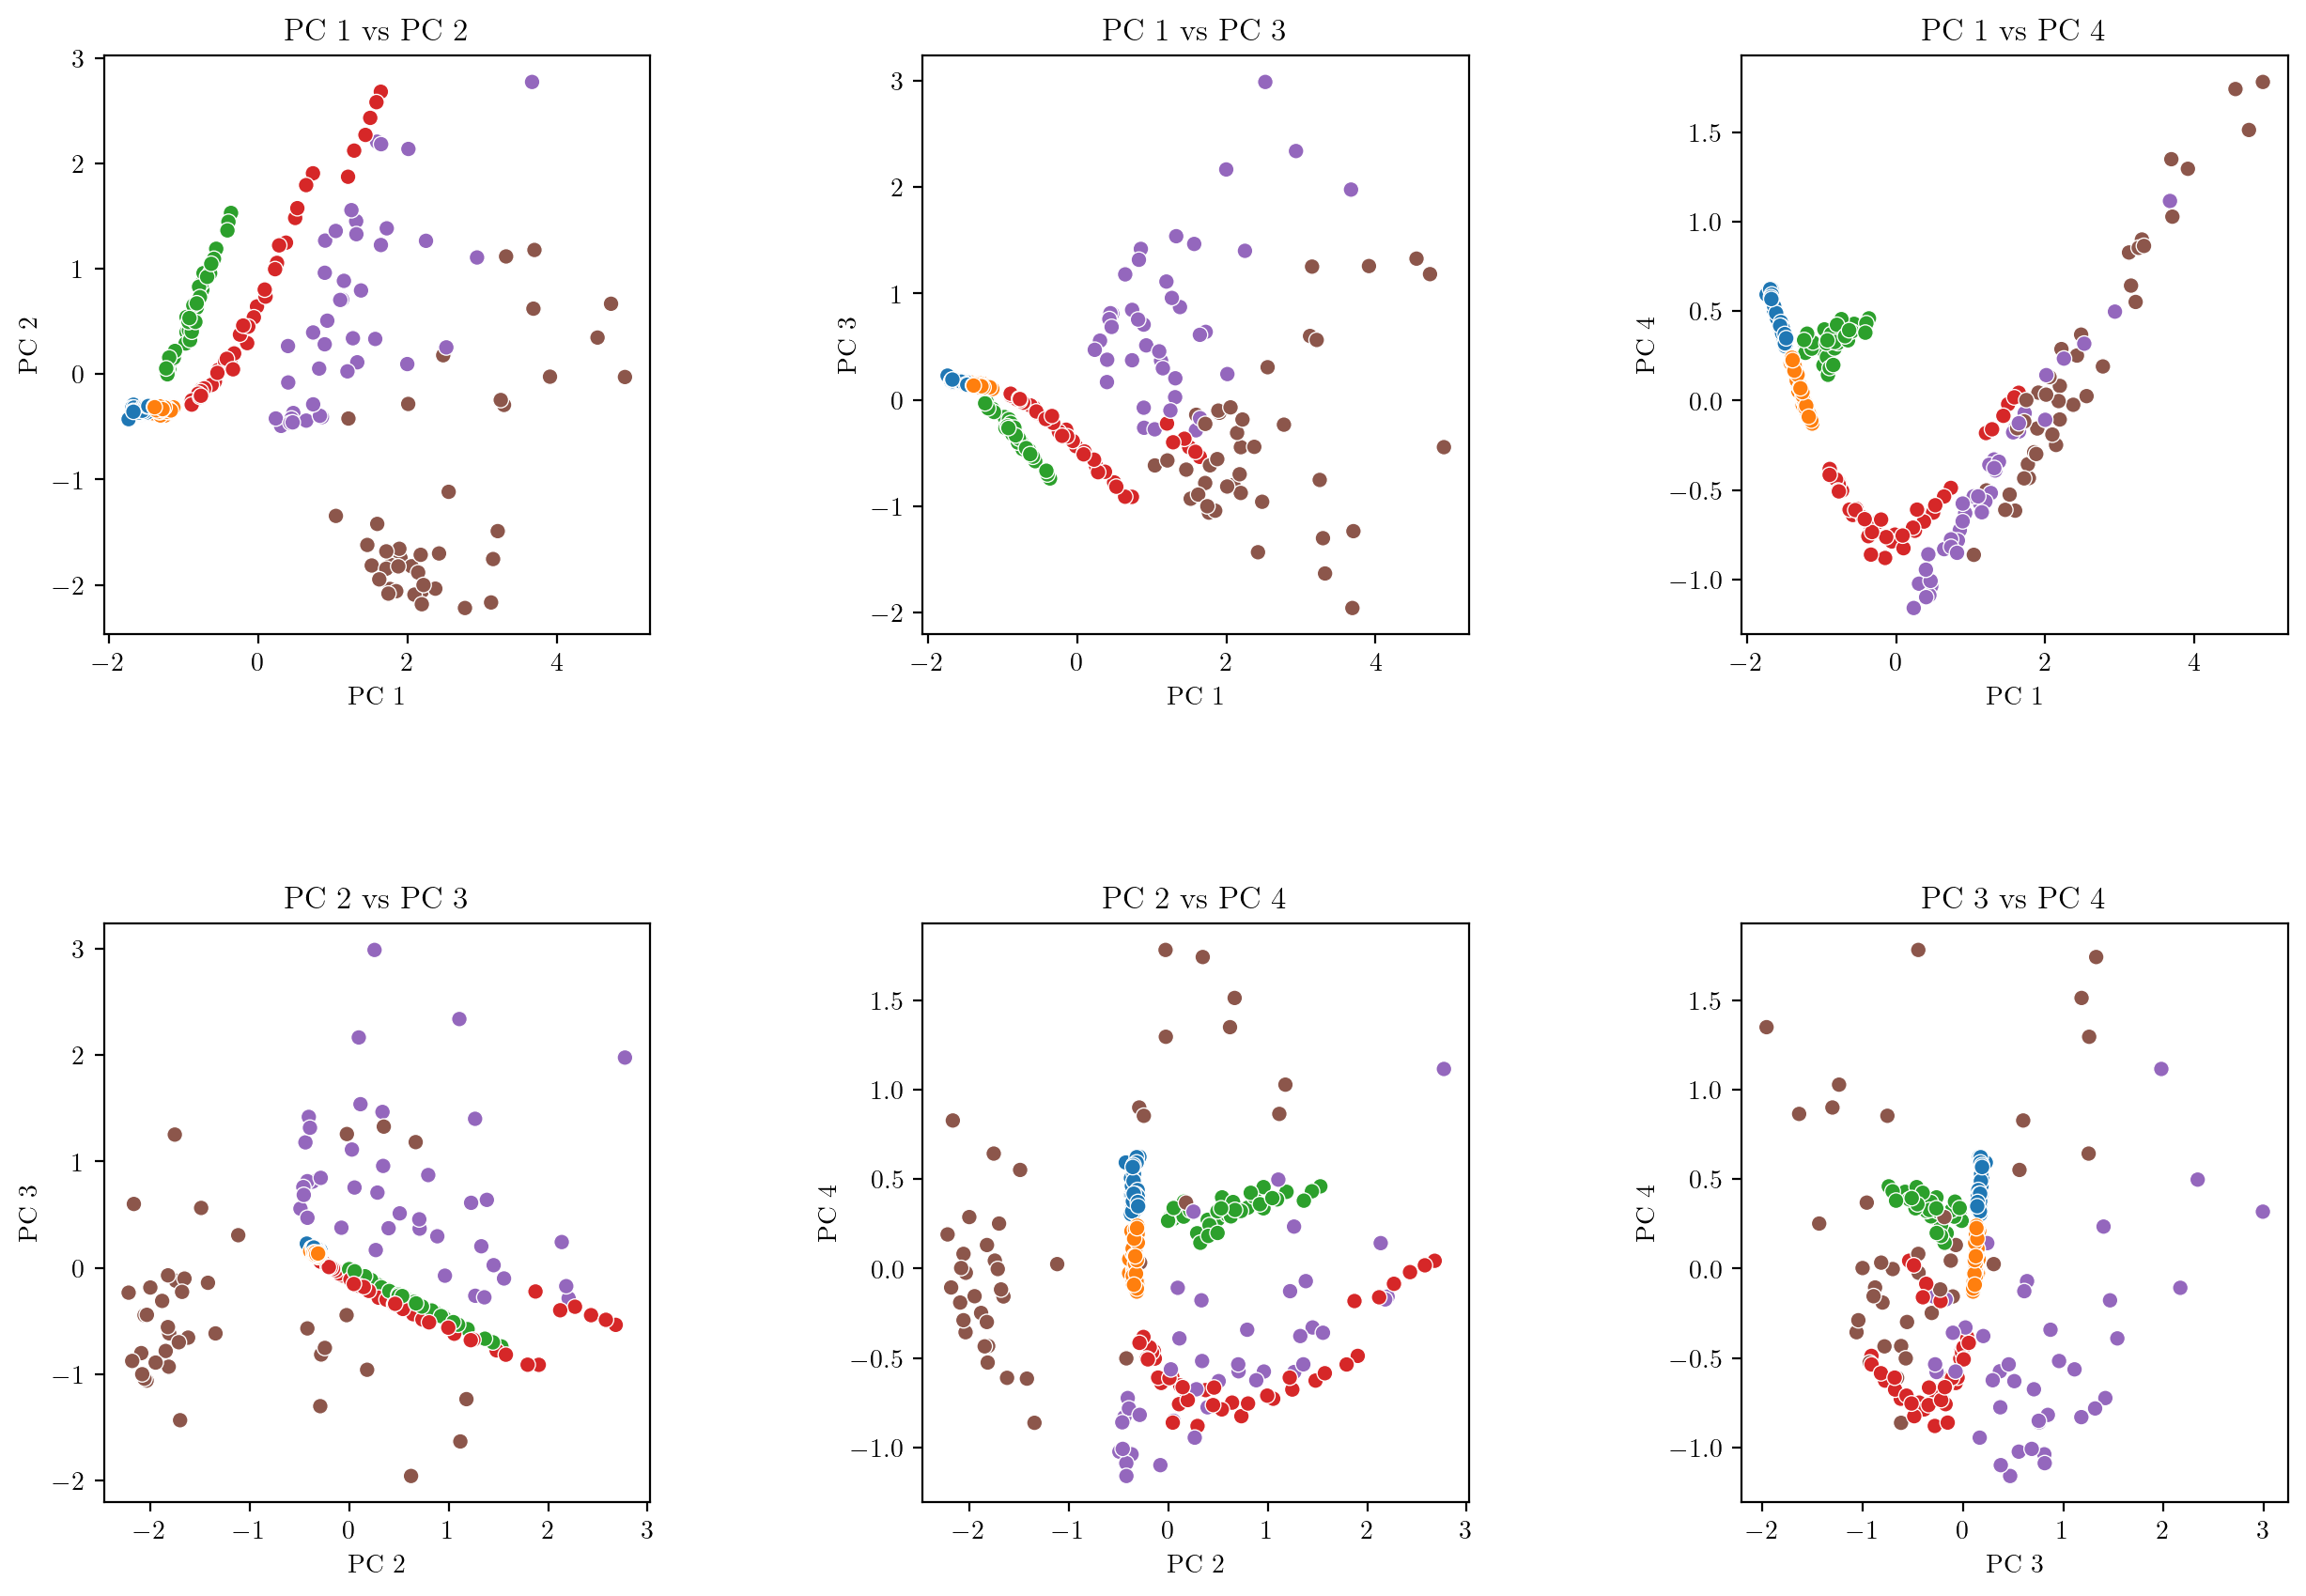

In [170]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
plt.subplots_adjust(hspace=0.5, wspace=0.5)

sns.scatterplot(x=stars_sc_transformed[:, 0], y=stars_sc_transformed[:, 1], hue=labels, ax=axs[0, 0], legend=False)
axs[0, 0].set_title('PC 1 vs PC 2')
axs[0, 0].set_xlabel('PC 1')
axs[0, 0].set_ylabel('PC 2')

sns.scatterplot(x=stars_sc_transformed[:, 0], y=stars_sc_transformed[:, 2], hue=labels, ax=axs[0, 1], legend=False)
axs[0, 1].set_title('PC 1 vs PC 3')
axs[0, 1].set_xlabel('PC 1')
axs[0, 1].set_ylabel('PC 3')

sns.scatterplot(x=stars_sc_transformed[:, 0], y=stars_sc_transformed[:, 3], hue=labels, ax=axs[0, 2], legend=False)
axs[0, 2].set_title('PC 1 vs PC 4')
axs[0, 2].set_xlabel('PC 1')
axs[0, 2].set_ylabel('PC 4')

sns.scatterplot(x=stars_sc_transformed[:, 1], y=stars_sc_transformed[:, 2], hue=labels, ax=axs[1, 0], legend=False)
axs[1, 0].set_title('PC 2 vs PC 3')
axs[1, 0].set_xlabel('PC 2')
axs[1, 0].set_ylabel('PC 3')

sns.scatterplot(x=stars_sc_transformed[:, 1], y=stars_sc_transformed[:, 3], hue=labels, ax=axs[1, 1], legend=False)
axs[1, 1].set_title('PC 2 vs PC 4')
axs[1, 1].set_xlabel('PC 2')
axs[1, 1].set_ylabel('PC 4')

sns.scatterplot(x=stars_sc_transformed[:, 2], y=stars_sc_transformed[:, 3], hue=labels, ax=axs[1, 2], legend=False)
axs[1, 2].set_title('PC 3 vs PC 4')
axs[1, 2].set_xlabel('PC 3')
axs[1, 2].set_ylabel('PC 4')

plt.show()


In [171]:
for idx, r in enumerate(evals):
    print(f'Comp {idx+1} - variance explained : {100*r:.2f} - cumulative : {evals.cumsum()[idx]*100}')

Comp 1 - variance explained : 60.36 - cumulative : 60.357390915734
Comp 2 - variance explained : 23.50 - cumulative : 83.8581750804348
Comp 3 - variance explained : 9.33 - cumulative : 93.18782024519136
Comp 4 - variance explained : 6.81 - cumulative : 100.0


The graphs with the first two components are the ones that divides better the different stars. Let's compare the first two with my rescaling and the first two with the standard one.

Text(0, 0.5, 'PC 2')

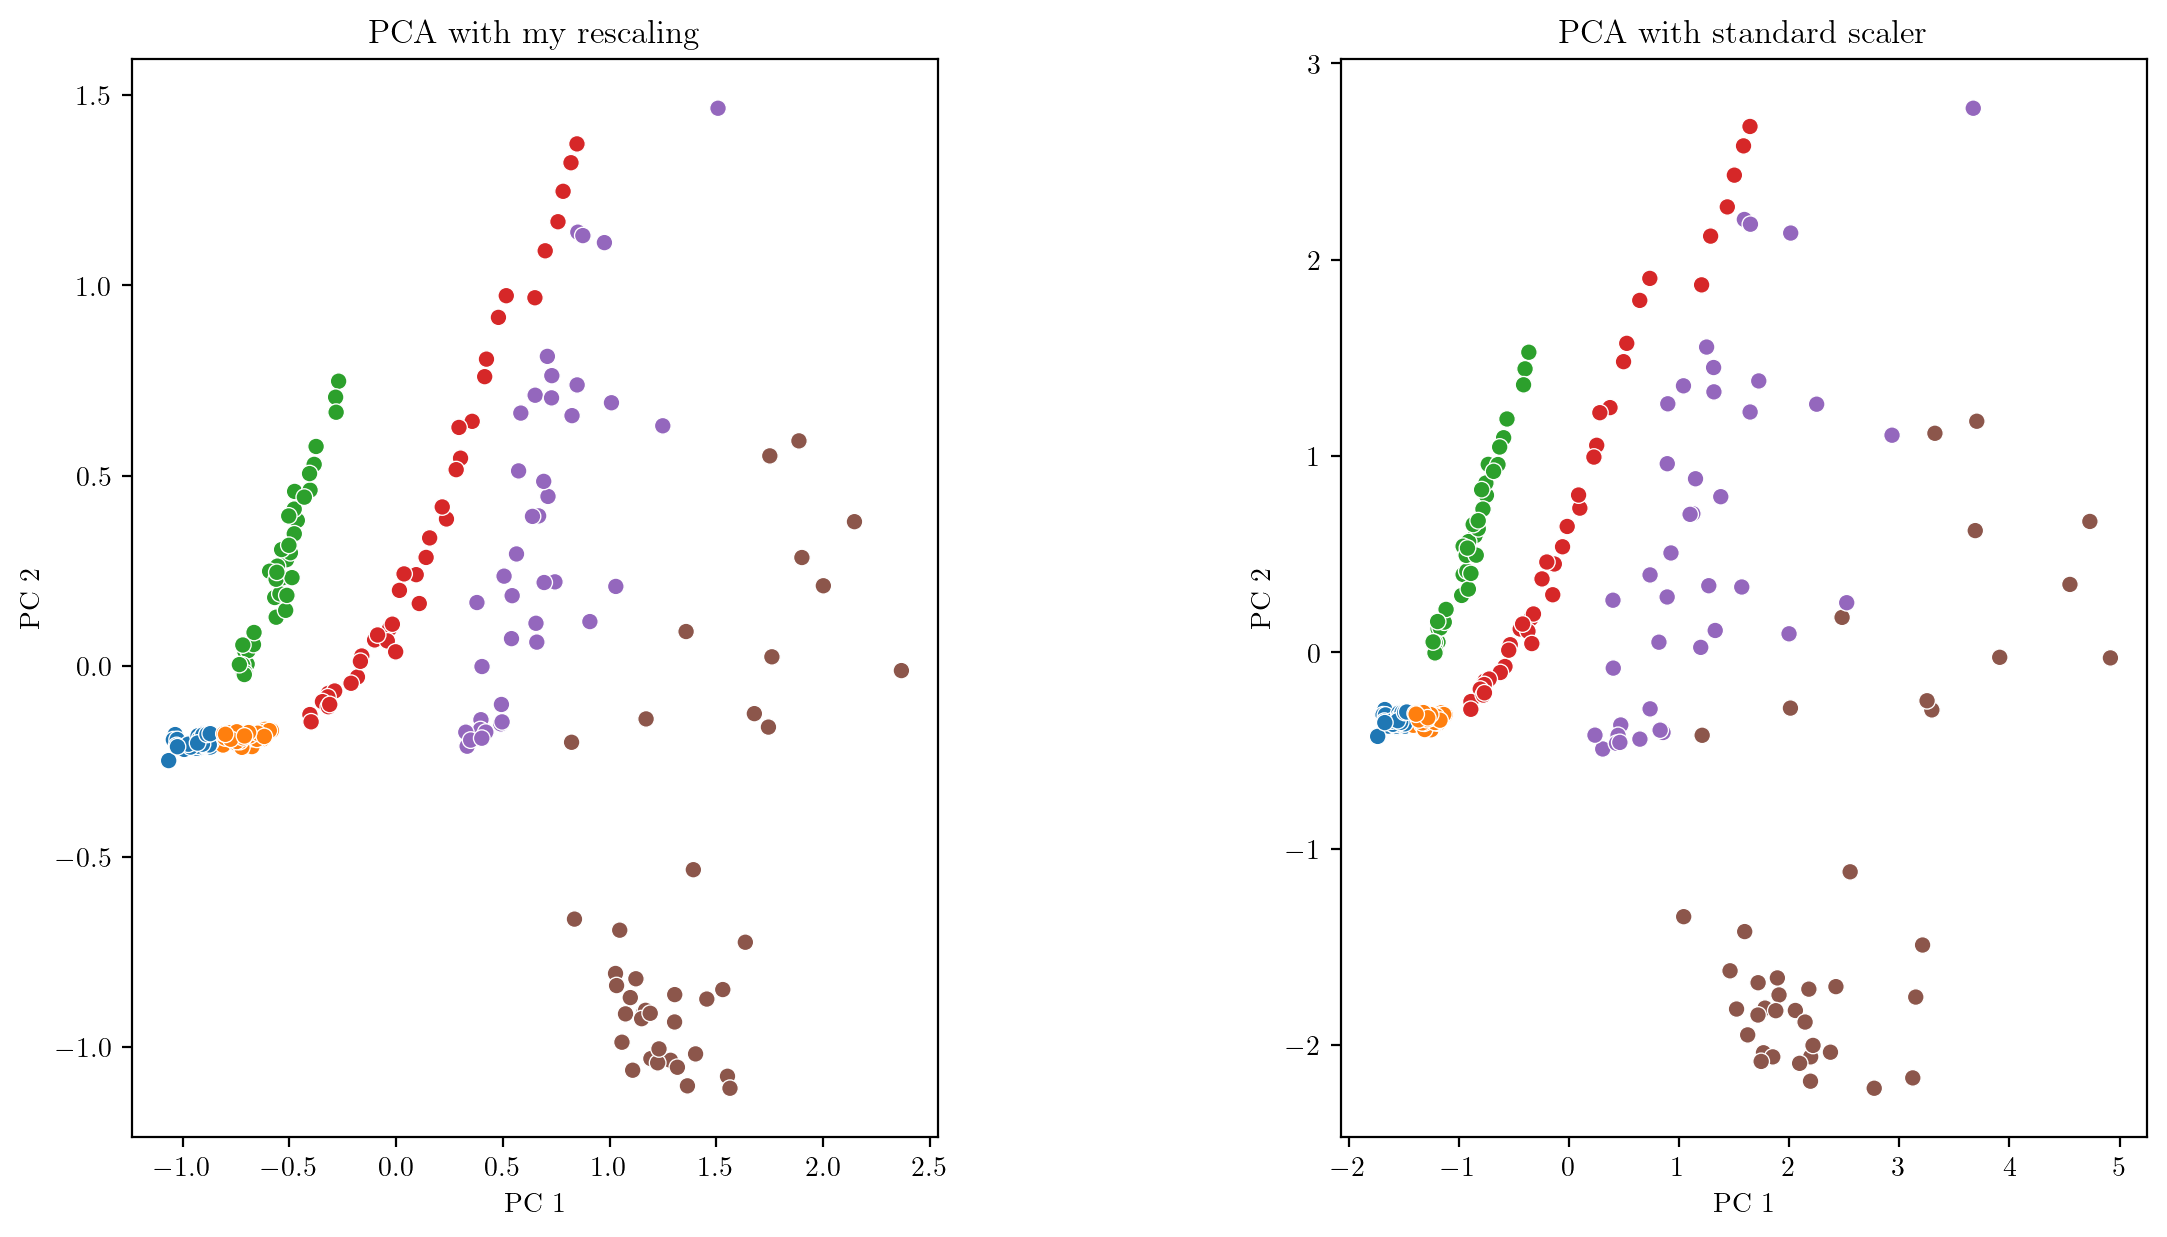

In [172]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(13, 7))
plt.subplots_adjust(hspace=0.5, wspace=0.5)

sns.scatterplot(x=my_stars_sc_transformed[:, 0], y=my_stars_sc_transformed[:, 1], hue=labels, ax=axs[0], legend=False)
axs[0].set_title('PCA with my rescaling')
axs[0].set_xlabel('PC 1')
axs[0].set_ylabel('PC 2')

sns.scatterplot(x=stars_sc_transformed[:, 0], y=stars_sc_transformed[:, 1], hue=labels, ax=axs[1], legend=False)
axs[1].set_title('PCA with standard scaler')
axs[1].set_xlabel('PC 1')
axs[1].set_ylabel('PC 2')


I am gonna use the supervised classification with the dimensions find with my scaling bc the points seem more clustered already and I think it's easier 

In [176]:
class_names

array(['Brown Dwarf', 'Hypergiant', 'Main Sequence', 'Red Dwarf',
       'Supergiant', 'White Dwarf'], dtype=object)

### come back to this assignment after lecture 20
- Now run a supervised classification algorithm on this dataset. 
- Can you predict the stellar type? How well? Careful with overfitting of course.

In [189]:
X = np.column_stack((my_stars_sc_transformed[:, 0], my_stars_sc_transformed[:, 1]))
lab = np.array(df_stars['Star type'])
X_train, X_test, lab_train, lab_test = train_test_split(X, lab, test_size=0.3, random_state=7)

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), 
    n_estimators=300, max_samples=100, 
    bootstrap=True, random_state=42, n_jobs=-1)

bag_clf.fit(X_train, lab_train)

lab_pred = bag_clf.predict(X_test)

print(f"Accuray = {accuracy_score(lab_test, lab_pred):.3f}")
print(confusion_matrix(lab_test, lab_pred))


Accuray = 0.986
[[16  0  0  0  0  0]
 [ 0  6  0  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  0 11  0  0]
 [ 0  1  0  0 12  0]
 [ 0  0  0  0  0 17]]


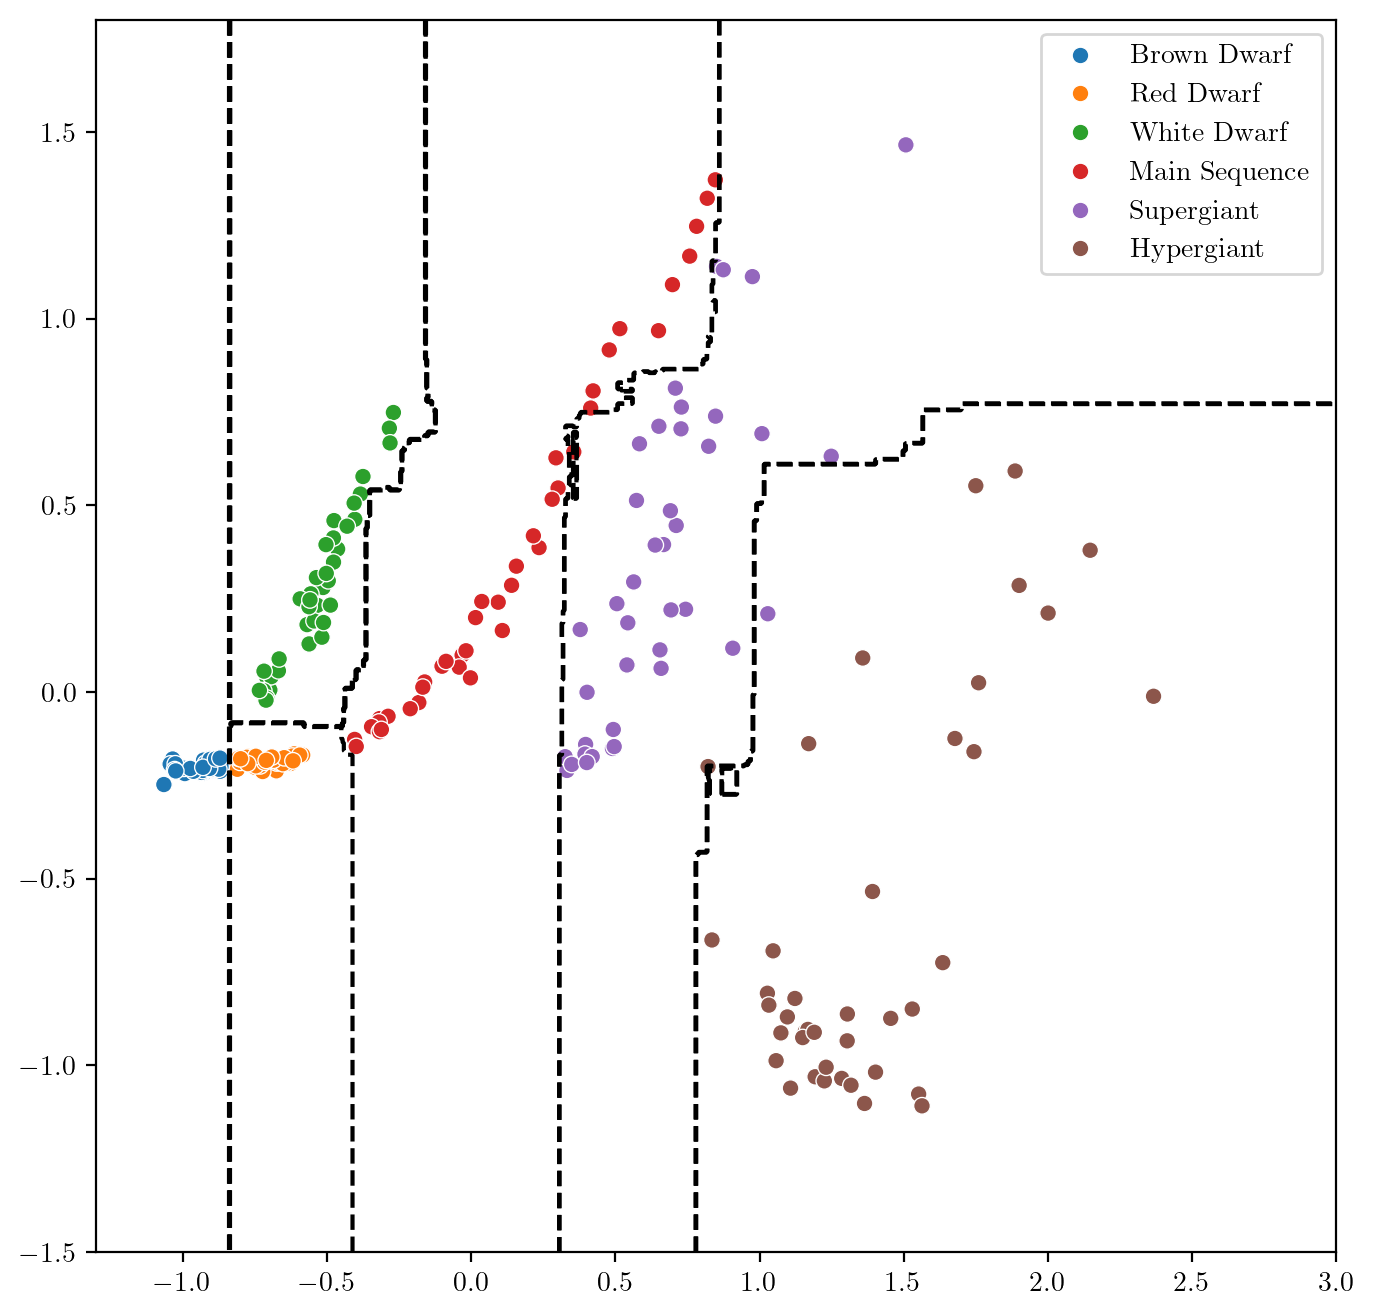

In [190]:
plt.figure(figsize=(8,8))

sns.scatterplot(x=my_stars_sc_transformed[:, 0], y=my_stars_sc_transformed[:, 1], hue=labels)

#decision boundaries:
xlim = (-1.3,3)
ylim = (-1.5,1.8)

xx,yy = np.meshgrid(np.linspace(xlim[0],xlim[1],1001),
                    np.linspace(ylim[0],ylim[1],1001))

xystack = np.vstack([xx.ravel(),yy.ravel()])
Xgrid = xystack.T

Z = bag_clf.predict(Xgrid)
Z = Z.reshape(xx.shape)

plt.contour(xx, yy, Z, colors='black', linestyles='--')

plt.show()